In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

C:\Users\hxia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
login = pd.read_csv('takehome_user_engagement.csv')
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
login.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:

#Convert the time columns to datetime
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')


#Convert to categorical
users.creation_source = users.creation_source.astype('category')

#Re-name user id appropriately
users['user_id'] = users['object_id']
users.drop('object_id', axis=1, inplace=True)

#Keep only info on if user was invited
users['invited'] = np.where(users['invited_by_user_id'].isnull(), True, False)
users.drop('invited_by_user_id', axis=1, inplace=True)

#We don't need personal information
users.drop(['name', 'email'], axis=1, inplace=True)

In [7]:

#Convert time column to datetime
login.time_stamp = pd.to_datetime(login.time_stamp)

#Drop visited column, its always 1
login.drop('visited', axis=1, inplace=True)

The heart of this problem is to correctly determine which users can be classified as adopted users. We can do this by grouping the engagement data by user. Then we can loop over the sorted time stamp data for a single user. Here we can simply construct a 7 day window from a given time stamp and demand the next two time stamps be within that window. Users who do not fill this criteria are not adopted users.

In [8]:
# time to add in the adopted user feature so that we can categorize the data
seven_days = datetime.timedelta(days=7)
adopted_dict = {}

for user_id in sorted(list(login['user_id'].unique())):
    
    adopted_user = 0
    temp = login[login['user_id'] == user_id]  ## iterate through the users
    temp = temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == 1:
            continue
        this_time = temp.get_value(row[0], 'time_stamp')
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
            adopted_user = 1
    
    adopted_dict[user_id] = adopted_user

C:\Users\hxia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [9]:
print('There are', sum(adopted_dict.values()), 'adopted users out of', len(adopted_dict), 'total users.')

There are 1656 adopted users out of 8823 total users.


In [10]:
dictlist=[]
for key, value in adopted_dict.items():
    temp = [key,value]
    dictlist.append(temp)

In [11]:
df= pd.DataFrame(dictlist, columns = ['user_id' , 'flag']) 
df['flag'].astype(int)
df.head()

,user_id,flag
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [12]:
users = pd.merge(users, df, on='user_id', how='outer')

#Re-code datetime columns
users['creation_year'] = users.creation_time.dt.year
users['creation_month'] = users.creation_time.dt.month
users['creation_day'] = users.creation_time.dt.day
users['last_session_year'] = users.last_session_creation_time.dt.year
users['last_session_month'] = users.last_session_creation_time.dt.month
users['last_session_day'] = users.last_session_creation_time.dt.day

#Drop unnecessary columns
users.drop(['creation_time', 'last_session_creation_time', 'user_id'], axis=1, inplace=True)

#Fill null values with something obvious for the model
users.last_session_day.fillna(0, inplace=True)
users.last_session_month.fillna(0, inplace=True)
users.last_session_year.fillna(0, inplace=True)

#Convert creation_source to indicator variables
users = pd.get_dummies(users, drop_first=True) #Drop first dummy column, since it is correlated to the others

#Define the target variable
target = 'flag'

#Define the x and y data
x = users.drop(target, axis=1).values
y = users[target].values

#Get the column names for x
df_columns = users.drop(target, axis=1).columns.values

In [24]:
users = pd.get_dummies(users, drop_first=True) #Drop first dummy column, since it is correlated to the others
users=users.dropna(axis=0, how='any')

In [32]:
x = users.drop(['flag','invited'], axis=1)
y = users['flag'].values

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=10, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
score_func = make_scorer(roc_auc_score, greater_is_better=True)

In [34]:
#Setup the RF object
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Hyperparameter grid
param_grid = {'n_estimators' : [40, 50, 60], 'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10]}

#Setup the Gridsearch
rf_cv = GridSearchCV(rf, param_grid, cv=cv, scoring=score_func, verbose=1)

#Fit the data
rf_cv.fit(x_train, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv.best_params_))
print('Best RF Score : %f' % rf_cv.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   52.9s finished


Best RF Params: {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 50}
Best RF Score : 0.915425


In [35]:
rf_best = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1, 
                                 n_estimators=rf_cv.best_params_['n_estimators'],
                                 min_samples_split=rf_cv.best_params_['min_samples_split'], 
                                 max_depth=rf_cv.best_params_['max_depth'])

rf_best.fit(x_train, y_train)

#Print the score/metric for the input model which must be fit
def get_scores(model, name='unk', score=roc_auc_score):
    
    #Make prediction for the model
    pred = model.predict(x_test)
    pred_prob = model.predict_proba(x_test)[:,1]

    #Calculate the score on the entire test set
    auc = score(y_test, pred_prob)
    
    #Calculate the score on CV test set
    cv_scores = cross_val_score(model, x_test, y_test, cv=cv, scoring=score_func)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    #Save to dataframe to be used for printing only
    model_score = pd.DataFrame(columns=['Model', 'Test score', 'CV score'])
    model_score.loc[0] = [name, auc, mean_cv]
    model_score.set_index('Model', inplace=True)
    print(model_score)

In [36]:
get_scores(rf_best, 'RF')

       Test score  CV score
Model                      
RF       0.980122  0.884837


In [37]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
   
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances by RandomForest Classifier')
    plt.show()
    
    return df

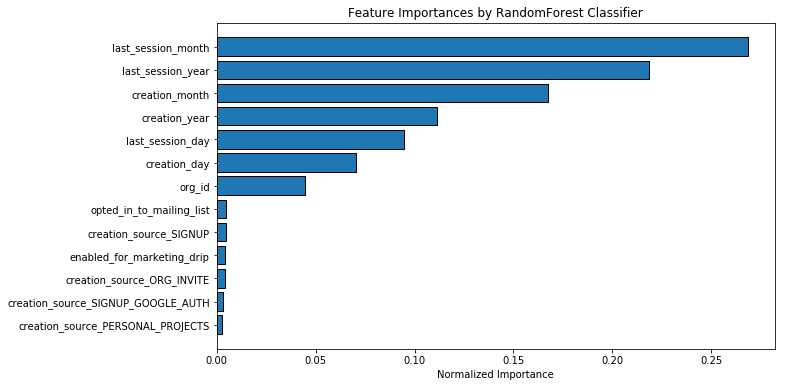

In [39]:
importance = rf_best.feature_importances_
feature = x.columns
fi = pd.DataFrame()
fi['importance'] = importance
fi['feature'] = feature
fi_sorted = plot_feature_importances(fi)